<a href="https://colab.research.google.com/github/ligiamarcia/Colaboratory/blob/main/Trabalho_final_Ammd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho final da disciplina de AMMD - ERE 2020

**Disciplina:** Aprendizagem de Máquina e Mineração de Dados ERE 2020

**Professor Dr Rafael Giusti** 

**Aluna:** 

*   Lígia Nascimento, Matrícula: 21752477


            

Objetivo:mostrar como funciona os modelos de classificação Árvores (algoritmo ID3) e Bayesianos (O algoritmo de Naive Bayes)

A base de dados escolhida foi o "weather", já estudado em sala de aula e que agora implementamos e explicamos os métodos tradicionais: Árvores (ID3) e Bayesiano (Naive Bayes). A dupla usou técnicas aprendidas durante as aulas ministradas na disciplina e pesquisamos sobre alguns pontos que consideramos interessantes aplicar para a melhor fixação do qprendizado.

# Preparação

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pydot

%matplotlib inline


In [ ]:
from IPython.display import Image, display, display_html

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

import networkx as nx

def plotg(g):
    to_pdot = nx.drawing.nx_pydot.to_pydot
    pdot = to_pdot(g)
    view_pydot(pdot)
    
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

In [ ]:
class DTdrawing:
    def __init__(self, target):
        self.id = 0
        self.g = []
        self.target = target
    
    def _node_name(self, ident, dct):
        return str(ident) + '. jogar = ' + (list(dct.keys())[0] if len(dct) == 1 else '?')

    def _draw(self, df, node, vnode = None, subnode = None):
        if vnode is not None:
            df = df[df[node]==vnode]
            node = subnode
            for n in self.g:
                if n[2]['label'] == vnode:
                    n[1] = subnode
        labels = df[node].value_counts().to_dict().keys()
        subnodes = [self._node_name(self.id + i, df[df[node]==l][self.target].value_counts().to_dict()) 
                    for i, l in enumerate(labels)]
        self.id += len(subnodes)
        n2n = dict(list(zip(labels, subnodes)))
        self.g = self.g + [[node, n2n[n], {'label': n}] for n in n2n]
        G = nx.DiGraph(self.g)
        plotg(G)
    
    def __call__(self, *args):
        if len(args) == 2:
            self._draw(df = args[0], node = args[1])
        else:
            self._draw(df = args[0], node = args[1], 
                      vnode = args[2], subnode = args[3])
    
dtdraw = DTdrawing('jogar')

In [ ]:
from collections.abc import MutableMapping

class CondProbTable(MutableMapping):
    """Conditional probabily table represented as a dictionary of dictionaries.
    If P is a CondProbTable, P['A|B'] is the same as P['A']['B']."""

    def __init__(self, *args, **kwargs):
        self.store = dict()
        self._update(dict(*args, **kwargs))

    def __getitem__(self, key):
        if '|' in key:
            [key1, key2] = key.split('|')
            return self.store[key1][key2]
        else:
            return self.store[key][key]

    def __setitem__(self, key, value):
        if '|' in key:
            [key1, key2] = key.split('|')
            if key1 not in self.store:
                self.store[key1] = dict()
            self.store[key1][key2] = value
        elif type(value) is not dict:
            if key not in self.store:
                self.store[key] = dict()
            self.store[key][key] = value
        else:
            self.store[key] = value

    def __delitem__(self, key):
        del self.store[key]

    def __iter__(self):
        return iter(self.store)
    
    def __len__(self):
        return len(self.store)
    
    def __repr__(self):
        dct = self.store.__repr__()
        return '%s(%s)' % (type(self).__name__, dct)
    
    def _update(self, dct):
        self.update(dct)

def dist_conjunta(A, B, normalize = False, laplace = 0, prev = None):
    # get crosstab
    ct = pd.crosstab(A, B)
    # applies Laplace's smoothing technique
    ct = ct + laplace
    # normlize columns
    if normalize:
        for c in ct:
            ct[c] = ct[c]/ct[c].sum()
    # rename cols and index so that variable name includes "var="
    ct.rename(columns = dict(zip(ct.columns, [B.name + '=' + c for c in ct.columns])), inplace = True)
    ct.index = [A.name + '=' + c for c in ct.index]
    # show table
    display(ct)
    # return CPT a dictionary so that it is easier to access P(A|B)
    if prev is None:
        return CondProbTable(ct.T.to_dict())
    else:
        prev._update(ct.T.to_dict())
        return prev

# Dados

In [ ]:
weather = {'ceu': ['ensolarado', 'ensolarado', 'nublado', 'chuvoso', 'chuvoso', 'chuvoso', 'nublado', 
                     'ensolarado', 'ensolarado', 'chuvoso', 'ensolarado', 'nublado', 'nublado', 'chuvoso'], 
          'temp': ['quente', 'quente', 'quente', 'media', 'fria', 'fria', 'fria', 
                        'media', 'fria', 'media', 'media', 'media', 'quente', 'media'],
          'umidade': ['alta', 'alta', 'alta', 'alta', 'normal', 'normal', 'normal', 
                     'alta', 'normal', 'normal', 'normal', 'alta', 'normal', 'alta'],
          'vento': ['F', 'V', 'F', 'F', 'F', 'V', 'V', 
                  'F', 'F', 'F', 'V', 'V', 'F', 'V'],
          'jogar': ['F', 'F', 'V', 'V', 'V', 'F', 'V', 
                 'F', 'V', 'V', 'V', 'V', 'V', 'F']}
wdf = pd.DataFrame(weather)[['ceu', 'temp', 'umidade', 'vento', 'jogar']]

In [ ]:
wdf

,ceu,temp,umidade,vento,jogar
0,ensolarado,quente,alta,F,F
1,ensolarado,quente,alta,V,F
2,nublado,quente,alta,F,V
3,chuvoso,media,alta,F,V
4,chuvoso,fria,normal,F,V
5,chuvoso,fria,normal,V,F
6,nublado,fria,normal,V,V
7,ensolarado,media,alta,F,F
8,ensolarado,fria,normal,F,V
9,chuvoso,media,normal,F,V


# Árvores - O algoritmo ID3



> 



Classificar uma série de instâncias pode ser pensado como organizar as instâncias em grupos homogêneos (em relação à variável alvo). Por exemplo, para a coleção _weather_, queremos ter grupos de instâncias nos quais jogar sempre é V ou sempre é F.

Dado um certo conjunto de grupos, podemos medir a homogeneidade por meio de sua entropia, ou _a quantidade de informação necessária para descrever o conjunto de grupos_. No caso da coleção _weather_, suponha que você considere a coleção inteira como um único grupo com 4 instâncias jogar=F e 9 instâncias jogar=V. Como medir a homogeneidade (ou quantidade de informação) nesse grupo? 

Primeiro, vamos pensar nele como uma sequência de símbolos jogar=F e jogar=V. A informação associada a uma sequencia de símbolos pode ser estimada como a entropia dessa sequencia de símbolos, ou seja, _a quantidade de informação necessária para transmitir essa sequência por um canal de comunicação_. Matematicamente, usando a formulação de Claude Shannon em seu trabalho sobre Teoria da Informação, temos:

$$info(s_1, ..., s_n) = entropy(s_1, ..., s_n) = \sum_{i=1}^{n} -P(s_i) \log P(s_i) $$

In [ ]:
def info(t):
    # obtenha seq de simbolos e suas probabilidades
    Ps = t.value_counts(normalize = True).to_dict()
    # calcule a entropia
    return sum([- Ps[s] * np.log2(Ps[s]) for s in Ps])

Para o caso da coleção Weather -- uma sequência de 9 jogar=V e 5 jogar=F -- a quantidade de informação é 0.94 bits:

In [ ]:
info_classes = info(wdf.jogar)
info_classes

0.9402859586706309

Imagine agora que queremos diminuir a quantidade de informação. Uma forma de fazer isso é dividir a coleção, usando informação dos atributos adicionais, para obter mais grupos de dados, de forma que cada grupo seja mais homogêneo que a coleção toda anterior (quanto mais homogêneo, menor a quantidade de informação e maior a entropia).

Assim, usando esse raciocício, **qual a quantidade de informação de uma nova segmentação dos nossos dados, feita de acordo com os valores do atributo _ceu_**?

Para tanto, vamos ver nossa coleção, segmentada de acordo com _ceu_:

In [ ]:
wdf.sort_values('ceu')

,ceu,temp,umidade,vento,jogar
3,chuvoso,media,alta,F,V
4,chuvoso,fria,normal,F,V
5,chuvoso,fria,normal,V,F
9,chuvoso,media,normal,F,V
13,chuvoso,media,alta,V,F
0,ensolarado,quente,alta,F,F
1,ensolarado,quente,alta,V,F
7,ensolarado,media,alta,F,F
8,ensolarado,fria,normal,F,V
10,ensolarado,media,normal,V,V


In [ ]:
pd.crosstab(wdf.ceu, wdf.jogar, margins = True)


jogar,F,V,All
ceu,,,
chuvoso,2,3,5
ensolarado,3,2,5
nublado,0,4,4
All,5,9,14


Notamos que ceu segmenta a coleção em três grupos: o primeiro com quatro instâncias (4 jogar=V e 0 jogar=F) correspondendo a 4/14 da coleção total; o segundo com 5 instâncias (3 jogar=V e 2 jogar=F) correspondendo a 5/14 da coleção total; e o terceiro com 5 instâncias (2 jogar=V e 3 jogar=F) correspondendo a 5/14 da coleção total. Logo, podemos calcular a informação deste novo arranjo como:


In [ ]:
print(wdf[wdf.ceu == 'nublado'].jogar.values)
print(wdf[wdf.ceu == 'chuvoso'].jogar.values)
print(wdf[wdf.ceu == 'ensolarado'].jogar.values)

['V' 'V' 'V' 'V']
['V' 'V' 'F' 'V' 'F']
['F' 'F' 'F' 'V' 'V']


In [ ]:
i_ceu_nublado = info(wdf[wdf.ceu == 'nublado'].jogar) 
i_ceu_chuvoso = info(wdf[wdf.ceu == 'chuvoso'].jogar)
i_ceu_ensolarado = info(wdf[wdf.ceu == 'ensolarado'].jogar)

i=dict([])
g=dict([])

i['ceu'] = (4./14.)*i_ceu_nublado + (5./14.)*i_ceu_chuvoso + (5./14.)*i_ceu_ensolarado
i['ceu']

0.6935361388961918

Logo, o **ganho de informação** associado com _outlook_ pode ser estimado como a diferença da quantidade de informação no conjunto não segmentado original e a quantidade do conjunto segmentado, ou seja:

In [ ]:
g['ceu'] = info_classes - i['ceu']
g['ceu']

0.2467498197744391

Assim, segmentando com ceu, nós conseguimos economizar 0.24 bits na representação da informação.

Vamos agora calcular o ganho de informação de todas as variáveis para determinar a mais informativa.

__Qual a quantidade de informação relacionada com _temp_?__

In [ ]:
pd.crosstab(wdf.temp, wdf.jogar, margins = True)

jogar,F,V,All
temp,,,
fria,1,3,4
media,2,4,6
quente,2,2,4
All,5,9,14


In [ ]:
i['temp'] = ((4./14.)*info(wdf[wdf.temp == 'fria'].jogar) + 
             (6./14.)*info(wdf[wdf.temp == 'media'].jogar) + 
             (4./14.)*info(wdf[wdf.temp == 'quente'].jogar))
g['temp'] = info_classes - i['temp']
g['temp']

0.029222565658954647

__Qual a quantidade de informação relacionada com _umidade_?__

In [ ]:
pd.crosstab(wdf.umidade, wdf.jogar, margins = True)

jogar,F,V,All
umidade,,,
alta,4,3,7
normal,1,6,7
All,5,9,14


In [ ]:
i['umidade'] = ((7./14.)*info(wdf[wdf.umidade == 'alta'].jogar) + 
                (7./14.)*info(wdf[wdf.umidade == 'normal'].jogar))
g['umidade'] = info_classes - i['umidade']
g['umidade']

0.15183550136234136

__Qual a quantidade de informação relacionada com _vento_?__

In [ ]:
pd.crosstab(wdf.vento, wdf.jogar, margins = True)

jogar,F,V,All
vento,,,
F,2,6,8
V,3,3,6
All,5,9,14


In [ ]:
i['vento'] = (8./14.)*info(wdf[wdf.vento == 'F'].jogar) + (6./14.)*info(wdf[wdf.vento == 'V'].jogar)
g['vento'] = info_classes - i['vento']
g['vento']

0.04812703040826927

Quando comparamos todos os ganhos obtidos:

In [ ]:
g

{'ceu': 0.2467498197744391,
 'temp': 0.029222565658954647,
 'umidade': 0.15183550136234136,
 'vento': 0.04812703040826927}

Observamos que claramente o maior ganho foi o do atributo ceu. Este então será escolhido como a raíz da árvore.

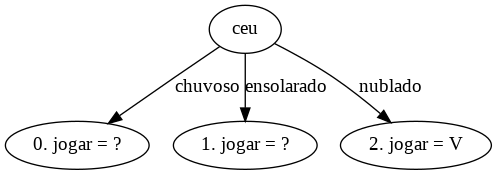

In [ ]:
dtdraw(wdf, 'ceu')

Usando ceu como raíz, notamos que uma folha da árvore já fica resolvida, ceu = nublado, já que ela leva a uma forma perfeitamente homogênea (neste caso, sempre jogar=V).

Vamos agora considerar os demais casos. Por exemplo, jogar = ensolarado.

Note que agora, para classificar apenas estes dados (jogar = V ocorre 2 vezes e jogar = F ocorre 3 vezes), é necessária a seguinte quantidade de informação:

In [ ]:
wdf2 = wdf[wdf.ceu=='ensolarado']
wdf2

,ceu,temp,umidade,vento,jogar
0,ensolarado,quente,alta,F,F
1,ensolarado,quente,alta,V,F
7,ensolarado,media,alta,F,F
8,ensolarado,fria,normal,F,V
10,ensolarado,media,normal,V,V


In [ ]:
info_classes = info(wdf2.jogar)
info_classes

0.9709505944546686

In [ ]:
i=dict([])
g=dict([])

Vamos considerar agora secções com as outras variáveis neste caso.

In [ ]:
pd.crosstab(wdf2.temp, wdf2.jogar, margins = True)

jogar,F,V,All
temp,,,
fria,0,1,1
media,1,1,2
quente,2,0,2
All,3,2,5


In [ ]:
i['temp'] = ((1./5.)*info(wdf2[wdf2.temp=='fria'].jogar) + 
             (2./5.)*info(wdf2[wdf2.temp=='quente'].jogar) + 
             (2./5.)*info(wdf2[wdf2.temp=='media'].jogar))
g['temp'] = info_classes - i['temp']
g['temp']

0.5709505944546686

In [ ]:
pd.crosstab(wdf2.umidade, wdf2.jogar)

jogar,F,V
umidade,,
alta,3,0
normal,0,2


In [ ]:
i['umidade'] = ((3./5.)*info(wdf2[wdf2.umidade=='alta'].jogar) + 
                (2./5.)*info(wdf2[wdf2.umidade=='normal'].jogar))
g['umidade'] = info_classes - i['umidade']
g['umidade']

0.9709505944546686

In [ ]:
pd.crosstab(wdf2.vento, wdf.jogar)

jogar,F,V
vento,,
F,2,1
V,1,1


In [ ]:
i['vento'] = (3./5.)*info(wdf2[wdf2.vento=='F'].jogar) + (2./5.)*info(wdf2[wdf2.vento=='V'].jogar)
g['vento'] = info_classes - i['vento']
g['vento']

0.01997309402197489

In [ ]:
g

{'temp': 0.5709505944546686,
 'umidade': 0.9709505944546686,
 'vento': 0.01997309402197489}

Logo, para outlook == ensolarado, o nó a ser considerado é umidade. Ao considerarmos apenas os valores de umidade, associados com ensolarado, observamos que a classe jogar sempre é V para umidade = alta e F para umidade = normal:

In [ ]:
wdf2[['ceu', 'umidade', 'jogar']]

,ceu,umidade,jogar
0,ensolarado,alta,F
1,ensolarado,alta,F
7,ensolarado,alta,F
8,ensolarado,normal,V
10,ensolarado,normal,V


Logo, nossa árvore fica:

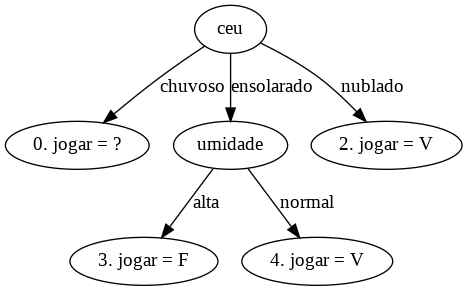

In [ ]:
dtdraw(wdf, 'ceu', 'ensolarado', 'umidade')

Vamos agora considerar o último caso: ceu = chuvoso. Para este caso, a quantidade de informação básica é dada por:

In [ ]:
wdf2 = wdf[wdf.ceu=='chuvoso']
wdf2

,ceu,temp,umidade,vento,jogar
3,chuvoso,media,alta,F,V
4,chuvoso,fria,normal,F,V
5,chuvoso,fria,normal,V,F
9,chuvoso,media,normal,F,V
13,chuvoso,media,alta,V,F


In [ ]:
info_classes = info(wdf[wdf.ceu=='chuvoso'].jogar)
info_classes

0.9709505944546686

In [ ]:
i=dict([])
g=dict([])

In [ ]:
pd.crosstab(wdf2.temp, wdf2.jogar)

jogar,F,V
temp,,
fria,1,1
media,1,2


In [ ]:
i['temp'] = (2./5.)*info(wdf2[wdf2.temp=='fria'].jogar) + (3./5.)*info(wdf2[wdf2.temp=='media'].jogar)
g['temp'] = info_classes - i['temp']
g['temp']

0.01997309402197489

In [ ]:
pd.crosstab(wdf2.umidade, wdf2.jogar)

jogar,F,V
umidade,,
alta,1,1
normal,1,2


In [ ]:
i['umidade'] = (2./5.)*info(wdf2[wdf2.umidade=='alta'].jogar) + (3./5.)*info(wdf2[wdf2.umidade=='normal'].jogar)
g['umidade'] = info_classes - i['umidade']
g['umidade']

0.01997309402197489

In [ ]:
pd.crosstab(wdf2.vento, wdf2.jogar)

jogar,F,V
vento,,
F,0,3
V,2,0


In [ ]:
i['vento'] = (3./5.)*info(wdf2[wdf2.vento=='F'].jogar) + (2./5.)*info(wdf2[wdf2.vento=='V'].jogar)
g['vento'] = info_classes - i['vento']
g['vento']

0.9709505944546686

In [ ]:
g

{'temp': 0.01997309402197489,
 'umidade': 0.01997309402197489,
 'vento': 0.9709505944546686}

Logo, para ceu == chuvoso, o nó a ser considerado é vento. Ao considerarmos apenas os valores de vento, associados com chuvoso, observamos que a classe jogar sempre é V para vento = V e F para Vento = F:

In [ ]:
wdf2[['ceu', 'vento', 'jogar']]

,ceu,vento,jogar
3,chuvoso,F,V
4,chuvoso,F,V
5,chuvoso,V,F
9,chuvoso,F,V
13,chuvoso,V,F


Logo, nossa árvore fica:

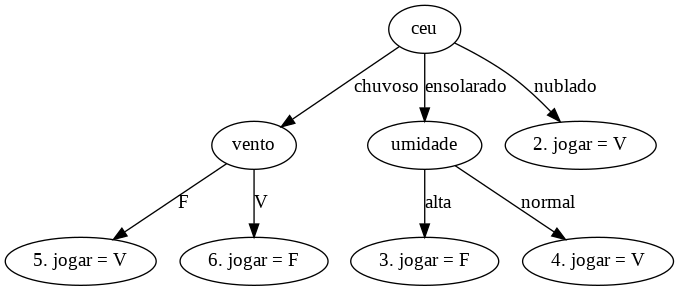

In [ ]:
dtdraw(wdf, 'ceu', 'chuvoso', 'vento')

#### Conclusões

Árvores são modelos _não_ lineares instáveis (ou seja, apresentam alta variância ante a diferentes amostras de treino) que geram modelos legíveis. Aspectos fundamentais sobre métodos de árvore:

* Modelo aprendido é compreensível por seres humanos o que é útil em problemas onde explicações são um requisito;
* Em geral, este modelo lida bem com variáveis numéricas e categóricas (sem necessidade de vetorização) e é robusto à ausência de normalização; ele é, contudo, sensível a desbalanceamento;
* Um _padrão_ é visto como uma regra geral que substitui várias observações e, desta forma, é útil para comprimir a representação original. Neste sentido, aprender está vinculado à noção de minimizar a entropia da informação via organização de dados e remoção de redundâncias;
* Algoritmos mais sofisticados como o C45 (J48 no Weka) e o C50 adotam critérios de parada mais sofisticados, que tentam evitar _overfitting_ e tomada de decisões baseadas em números pequenos de amostras. Exemplos são estratégias de poda (que reduzem o tamanho da árvore), tomadas de decisão baseadas em números mínimos de instâncias e impossibilidade de criar árvores com profundidade maior que um certo limite; 
* A instabilidade destes modelos pode ser mitigada com o uso deles como parte de _ensambles_.
* Regras podem ser derivadas diretamente de árvores, o que possibilita toda uma família variante de estratégias, as baseadas em regras;
* Se as folhas representarem funções numéricas, o modelo pode ser usado para regressão;
* Há uma versão do modelo para aprendizado incremental, as Árvores de Hoeffding;

# Bayesianos - O algoritmo Naive Bayes

O algoritmo NaiveBayes usa diretamente a Teoria de Decisão Bayesiana, ou seja, dada a instância $I$ e classes possíveis $C$, a classe mais provável é aquela que minimiza o risco de classificação de acordo com a regra de Bayes, ou seja (onde $\eta$ é uma constante de normalização):

$$
\begin{align}
c* & = \arg \max_c P(C = c|I) \\
& = \arg \max_c P(I|C = c) \\
& \sim \arg \max_c P(I|C = c)+ logP(C = c) 
\end{align}
$$

Para estimar $ P(I|C = c)$, o algoritmo assume que se a instância $I$ é representada pelos atributos $a_1, a_2, ..., a_n$, então $P(I|C = c) \approx \prod_{i=1}^{n} P(a_i | C = c) \sim \sum_{i=1}^{n} \log P(a_i | C = c)$. Para tanto, é usada uma abordagem de estimativa de risco empírico, ou seja, as probabilidades $P(I|C = c)$ e $P(C = c)$ são estimadas da coleção de treino. A equação resultante se torna:

$$
\begin{align}
c* \sim \arg \max_c \big(\sum_{i=1}^{n} \log P(a_i | C = c)\big) + \log P(C = c)
\end{align}
$$

Vamos considerar a coleção weather, supondo que os dados que temos correspondem a uma amostra (de treino) de uma população maior de jogos. 

Primeiro, estimamos as probabilidades $P(jogar=V)$ e $P(jogar=F)$ diretamente da distribuição da variável jogar:

In [ ]:
wdf.jogar.value_counts().to_dict()

{'F': 5, 'V': 9}

Logo, $P(jogar=V) = \frac{9}{9+5} = 0.64$ e $P(jogar=F) = \frac{5}{9+5} = 0.36$.

No caso de $P(a_i | C = c)$, podemos fazer estimativas apartir das ocorrências conjuntas de $a_i$ e $C$. Por exemplo, para ceu, temos:

In [ ]:
pd.crosstab(wdf.ceu, wdf.jogar, margins=True)

jogar,F,V,All
ceu,,,
chuvoso,2,3,5
ensolarado,3,2,5
nublado,0,4,4
All,5,9,14


Desta tabela, por exemplo, podemos estimar $P(ceu = nublado~|~jogar = V) = 4/9 = 0.44$. Da mesma forma, $P(ceu = nublado~|~jogar = F) = 0/5 = 0$. 

Para este segundo caso, contudo, note que estamos estimando do treino que é impossível se observar um jogo de tênis com o céu nublado. De fato, desde que estamos fazendo estimativas com base em uma amostra da população real, não deveríamos ser tão rigorosos e supor que a probabilidade de um evento que não vimos é zero. Podemos imaginar que este é apenas um evento raro, mas não necessariamente impossível. Assim, devemos considerar a axistência de uma pequena probabilidade para o evento. Como regra geral, para evitar probabilidades nulas, vamos aplicar alguma técnica de suavização: por exemplo, adicionar 1 a todos os contadores, o que é conhecido como técnica de suavização de Laplace:

In [ ]:
original = pd.crosstab(wdf.ceu, wdf.jogar)
apos_laplace = pd.crosstab(wdf.ceu, wdf.jogar) + 1
display_side_by_side(original, apos_laplace)

jogar,F,V
ceu,,
chuvoso,2,3
ensolarado,3,2
nublado,0,4
jogar,F,V
ceu,,
chuvoso,3,4
ensolarado,4,3
nublado,1,5


In [ ]:
apos_laplace['P(ceu|F)'] = apos_laplace['F'] / apos_laplace['F'].sum()
apos_laplace['P(ceu|V)'] = apos_laplace['V'] / apos_laplace['V'].sum()

In [ ]:
apos_laplace

jogar,F,V,P(ceu|F),P(ceu|V)
ceu,,,,
chuvoso,3,4,0.375,0.333333
ensolarado,4,3,0.500,0.250000
nublado,1,5,0.125,0.416667


Uma questão interessante é se há ou não necessidade de aplicar Laplace às estimativas de classes. Se aplicarmos Laplace, temos:

$P(jogar=V) = \frac{9+1}{(9+1)+(5+1)} = 0.625$ e $P(jogar=F) = \frac{5+1}{(9+1)+(5+1)} = 0.375$.

In [ ]:
wdf.jogar.value_counts(normalize=True)['V']

0.6428571428571429

In [ ]:
P = CondProbTable([])
P['jogar=V'] = wdf.jogar.value_counts(normalize=True)['V']
P['jogar=F'] = wdf.jogar.value_counts(normalize=True)['F']

Se aplicarmos o que vimos até agora para todas as variáveis, temos (desta vez usando meu método `dist_conjunta`):

In [ ]:
for c in ['ceu', 'temp', 'umidade', 'vento']:
    P = dist_conjunta(wdf[c], wdf.jogar, laplace = 1, normalize = True, prev=P)

jogar,jogar=F,jogar=V
ceu=chuvoso,0.375,0.333333
ceu=ensolarado,0.500,0.250000
ceu=nublado,0.125,0.416667


jogar,jogar=F,jogar=V
temp=fria,0.250,0.333333
temp=media,0.375,0.416667
temp=quente,0.375,0.250000


jogar,jogar=F,jogar=V
umidade=alta,0.714286,0.363636
umidade=normal,0.285714,0.636364


jogar,jogar=F,jogar=V
vento=F,0.428571,0.636364
vento=V,0.571429,0.363636


Com todas as probabilidades estimadas do treino, podemos fazer inferência para novos casos de teste. Por exemplo, qual a probabilidade $P(jogar~|~I)$ para $I$ dado por:

$I$ = {ceu = ensolarado, temp = fria, umidade = alta, vento = V}

Para tanto precisamos calcular $P(jogar~|~I)=\eta~P(I~|~jogar)P(jogar)$:

In [ ]:
P['jogar=V|I'] = (P['ceu=ensolarado|jogar=V'] * 
                  P['temp=fria|jogar=V'] *
                  P['umidade=alta|jogar=V'] *
                  P['vento=V|jogar=V'] * 
                  P['jogar=V'])
P['jogar=F|I'] = (P['ceu=ensolarado|jogar=F'] * 
                  P['temp=fria|jogar=F'] *
                  P['umidade=alta|jogar=F'] *
                  P['vento=V|jogar=F'] * 
                  P['jogar=F'])
eta = 1 / (P['jogar=V|I'] + P['jogar=F|I'])

In [ ]:
eta*P['jogar=V|I'], eta*P['jogar=F|I']

(0.27993334920257085, 0.7200666507974292)

Como podemos ver $P(I|jogar=V) < P(I|jogar=F)$. Logo, dado $I$, é mais provável que _não_ haja jogo.

#### E para o caso de atributos numericos? use uma estimativa Gaussiana

Para atributos numéricos, uma estimativa uniforme não é adequada, uma vez que, para cada valor possível, ela será baseada em uma pequena amostra. Uma alternativa é usar uma estimativa contínua. Por exemplo, supondo que a variável numérica segue uma distribuição Gaussiana, podemos obter estimativas de probabilidade para os valores usando a função de desensidade de probabilidade da distribuição normal:

$$f(x|\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\frac{-(x-\mu)^2}{2 \sigma^2}}$$

Em python:

In [ ]:
gaussian_prob = lambda x, mu, sigma: 1./np.sqrt(2. * np.pi * sigma**2) * np.exp(-(x-mu)**2/(2*sigma**2))

Por exemplo, para o exemplo abaixo:

In [ ]:
weathern = {'ceu': ['ensolarado', 'ensolarado', 'nublado', 'chuvoso', 'chuvoso', 'chuvoso', 'nublado', 
                     'ensolarado', 'ensolarado', 'chuvoso', 'ensolarado', 'nublado', 'nublado', 'chuvoso'], 
          'temp': [85.0, 80.0, 83.0, 70.0, 68.0, 65.0, 64.0, 72.0, 
                          69.0, 75.0, 75.0, 72.0, 81.0, 71.0],
          'umidade': [85.0, 90.0, 86.0, 96.0, 80.0, 70.0, 65.0, 
                       95.0, 70.0, 80.0, 70.0, 90.0, 75.0, 91.0],
          'vento': ['F', 'V', 'F', 'F', 'F', 'V', 'V', 
                  'F', 'F', 'F', 'V', 'V', 'F', 'V'],
          'jogar': ['F', 'F', 'V', 'V', 'V', 'F', 'V', 
                 'F', 'V', 'V', 'V', 'V', 'V', 'F']}
wndf = pd.DataFrame(weathern)[['ceu', 'temp', 'umidade', 'vento', 'jogar']]

In [ ]:
wndf

,ceu,temp,umidade,vento,jogar
0,ensolarado,85.0,85.0,F,F
1,ensolarado,80.0,90.0,V,F
2,nublado,83.0,86.0,F,V
3,chuvoso,70.0,96.0,F,V
4,chuvoso,68.0,80.0,F,V
5,chuvoso,65.0,70.0,V,F
6,nublado,64.0,65.0,V,V
7,ensolarado,72.0,95.0,F,F
8,ensolarado,69.0,70.0,F,V
9,chuvoso,75.0,80.0,F,V


Podemos estimar os seguintes parâmetros $\mu$ e $\sigma$ para os atributos temperatura e umidade:

In [ ]:
tempFmu, tempFsigma = wndf[wndf.jogar=='F'].temp.mean(), wndf[wndf.jogar=='F'].temp.std()
tempVmu, tempVsigma = wndf[wndf.jogar=='V'].temp.mean(), wndf[wndf.jogar=='V'].temp.std()

O que representariam as seguintes distribuições, considerando o caso particular da temperatura:

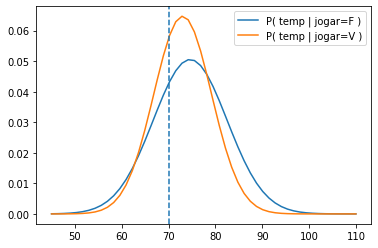

In [ ]:
x = np.linspace(45, 110)
plt.plot(x, stats.norm.pdf(x, tempFmu, tempFsigma), label='P( temp | jogar=F )')
plt.plot(x, stats.norm.pdf(x, tempVmu, tempVsigma), label='P( temp | jogar=V )')
plt.axvline(x=70, linestyle = '--')
plt.legend()

In [ ]:
gaussian_prob(70, tempFmu, tempFsigma), gaussian_prob(70, tempVmu, tempVsigma),

(0.04264937407110744, 0.05748951672082569)

Neste caso, para a temperatura 70 graus, é mais provável jogar = F. Para um exemplo mais complexo, vamos considerar o caso:

$I$ = {ceu = ensolarado, temp = 73, umidade = 90, vento = V}

Primeiro estimamos os parâmetros para temp = 73 e umidade = 90 e, em seguida, suas probabilidades:

In [ ]:
tempFmu, tempFsigma = wndf[wndf.jogar=='F'].temp.mean(), wndf[wndf.jogar=='F'].temp.std()
tempVmu, tempVsigma = wndf[wndf.jogar=='V'].temp.mean(), wndf[wndf.jogar=='V'].temp.std()

umFmu, umFsigma = wndf[wndf.jogar=='F'].umidade.mean(), wndf[wndf.jogar=='F'].umidade.std()
umVmu, umVsigma = wndf[wndf.jogar=='V'].umidade.mean(), wndf[wndf.jogar=='V'].umidade.std()

print(gaussian_prob(73, tempFmu, tempFsigma), gaussian_prob(73, tempVmu, tempVsigma))
print(gaussian_prob(90, umFmu, umFsigma), gaussian_prob(90, umVmu, umVsigma))

0.04951572453448171 0.06471698367586758
0.037986049936266336 0.022127532669816825


Agora, podemos estimar os demais valores:

\begin{align}
P(I|jogar = V) P(jogar = V) &= P(ceu = ensolarado~|~jogar = V) \\
&\times P(temp = 73~|~jogar = V) \\
&\times P(umidade = 90~|~jogar = V) \\
&\times P(vento = true~|~jogar = V)~P(jogar = V) \\
&= 0.25 \times 0.33 \times 0.065 \times 0.022 \times 0.625 \\
&= 7.3734375e-05
\end{align}

\begin{align}
P(I|jogar = F) P(jogar = F) &= P(ceu = ensolarado~|~jogar = F) \\
&\times P(temp = 73~|~jogar = F) \\
&\times P(umidade = 90~|~jogar = F) \\
&\times P(vento = true~|~jogar = F)~P(jogar = F) \\
&= 0.50 \times 0.25 \times 0.049 \times 0.038 \times 0.375 \\
&= 8.728125e-05
\end{align}

Como podemos ver $P(I|jogar=V) \approx \frac{7.3734375e-05}{7.3734375e-05+8.728125e-05} = 0.46$ < $P(I|jogar=F) \approx \frac{8.728125e-05}{7.3734375e-05+8.728125e-05} = 0.54$. Logo, dado $I$, é mais provável que _não_ haja jogo.

#### Naive Bayes e hiperplanos de separação

Imagine que gostaríamos de separar SPAM de HAM usando NB. Em particular, temos que tomar uma decisão relacionada com a mensagem `gratis gratis clique aqui aqui aqui`. Sem vetorização, podemos tratar cada palavra como um atributo e resolver a decisão:

$P(SPAM) P(gratis|SPAM) P(gratis|SPAM) P(clique|SPAM) P(aqui|SPAM) P(aqui|SPAM) P(aqui|SPAM) >
P(HAM) P(gratis|HAM) P(gratis|HAM) P(clique|HAM) P(aqui|HAM) P(aqui|HAM) P(aqui|HAM)$?

Isto equivale a:

$
=\log P(SPAM) + \log P(gratis|SPAM) + \log P(gratis|SPAM) + \log P(clique|SPAM) + \log P(aqui|SPAM) + \log P(aqui|SPAM) + \log P(aqui|SPAM) >
\log P(HAM)  + \log P(gratis|HAM) + \log P(gratis|HAM) + \log P(clique|HAM) + \log P(aqui|HAM) + \log P(aqui|HAM) + \log P(aqui|HAM)\\
= \log P(SPAM) + 2 \log P(gratis|SPAM) + \log P(clique|SPAM) + 3 \log P(aqui|SPAM) > \log P(HAM) + 2 \log P(gratis|HAM) + \log P(clique|HAM) + 3 \log P(aqui|HAM) \\
= 2 (\log P(gratis|SPAM) - \log P(gratis|HAM)) + (\log P(clique|SPAM) - \log P(clique|HAM)) + 3 (\log P(aqui|SPAM) - \log P(aqui|HAM)) + \log P(SPAM) - \log P(HAM) > 0 
$ 

Com ${\bf w} = \begin{pmatrix} 2\\ 1\\ 3 \end{pmatrix}$, ${\bf x} = \begin{pmatrix} x_0~x_1~x_2 \end{pmatrix}$, onde $x_i = \log P(x_i|SPAM) - \log P(x_i|HAM)$ e $b = \log P(SPAM) - \log P(HAM)$, observamos que a decisão do Naive Bayes corresponde a encontrar um plano de separação linear:

${\bf w} \dot~{\bf x} + b > 0$

#### Conclusões

Método linear baseado em toeria de decisão Bayesiana. Aspectos fundamentais sobre o Naive Bayes:

* Método naturalmente incremental, já que dada uma nova instância, não é preciso recalcular todas as probabilidades, mas apenas atualizar as que foram afetadas. Apropriado para aplicações online;
* Aplicação direta da Teoria de Decisão Bayesiana e da Teoria de Risco Empírico;
* Embora seja um método ok para classificação, não é muito bom como estimador (ou seja, embora possa até acertar as classes, suas estimativas de probabilidade não são as melhores);
* Primeiro tratamento do problema como um problema de incerteza. No futuro, isto vai abrir caminho para, além da detecção de padrões, a sua geração;
* Estimativas comumente empregadas para $P(x_i|y)$ incluem:
    * _Gaussiana_ (vista antes): $P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$, com $\sigma_y$ e $\mu_y$ estimados via máxima verossimelhança.
    * _Multinomial_: no caso de texto, é comum assumirmos que a entrada seque uma distribuição multinomial parametrizada por $\theta_y = (\theta_{y1},\ldots,\theta_{yn})$, para cada classe $y$, onde $n$ é o número de features (o tamanho do vocabulário) e $P(x_i \mid y)$ á a probabilidade de $x_i$ aparecer em uma amostra pertencente a $y$. $\theta_y$ é estimada como a verossimelhança máxima com suavização, ou seja, $\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$, onde $N_{yi}$ é o número de vezes que $x_i$ aparece em uma amostra de $y_i$ (no treino), $N_y$ é o total de palavras vistas em $y_i$ (a soma de todos $N_{yi}$) e a $\alpha$ é o incremento de suavização.
    * _Bernoulli_: para casos em que assumimos que a entrada segue uma distribuição de Bernoulli. Nesses casos, os valores das features são binários e $P(x_i \mid y) = P(i \mid y) x_i + (1 - P(i \mid y)) (1 - x_i)$, onde $i$ (0 ou 1) é o valor da feature $x_i$.